## Set up

In [ ]:
# Data Manipulation & Analysis
import numpy as np
import pandas as pd

# File & System Operations
import pathlib
import os
import sys
import toml

# Data Preprocessing & Transformation (scikit-learn)
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Dimensionality Reduction & Manifold Learning (scikit-learn)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Clustering (scikit-learn)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Data Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting
import seaborn as sns
import plotly.express as px

# Outlier Detection (scipy)
from scipy.stats import zscore

# Non-linear Dimensionality Reduction
import umap.umap_ as umap
from kneed import KneeLocator

from term_deposit import visualization as vis
from term_deposit import preprocessing as pp

/opt/conda/envs/term_deposit-cluster/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
while os.path.basename(cwd := os.getcwd()) != "2-term_deposit_marketing":
    os.chdir("..")
    print(f"{cwd=:}")

sys.path.append("./term_deposit")
import term_deposit as td

# Load the configuration file
config = toml.load('config.toml')
target_col = 'y'

cwd=/workspaces/2-term_deposit_marketing/notebooks


## Load and transform the data

In [3]:
# Configuration loading
from term_deposit import utils
config = utils.load_config()

# Data loading
features, target = utils.load_data(config)

# Feature separation
numerical_features = config['data']["separation"]["numerical_features"]
categorical_features = config['data']["separation"]["categorical_features"]

In [4]:
# Create the preprocessor
preprocessor = utils.create_preprocessor(numerical_features, categorical_features)

# Fit and transform the dataset using the preprocessor
processed_features = preprocessor.fit_transform(features)

# Get feature names for the transformed data
feature_names = preprocessor.get_feature_names_out()

# Feature engineering
processed_df = utils.add_interaction_features(processed_features, feature_names)

## Modeling

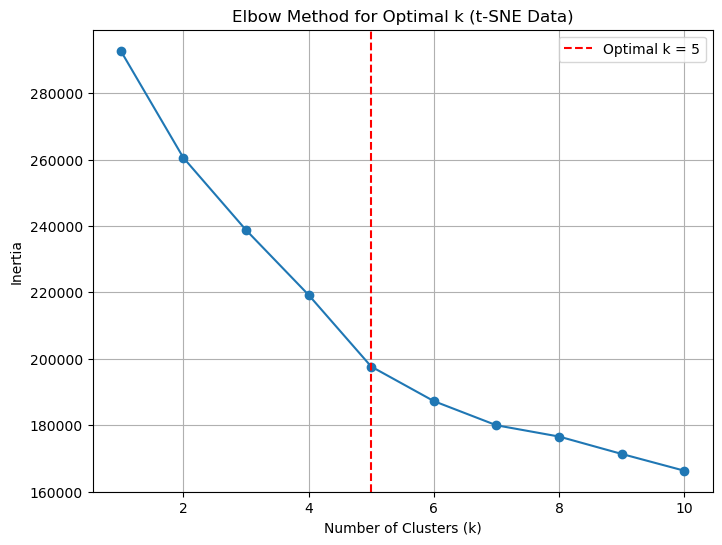

np.int64(5)

In [5]:
# Determine the optimal number of clusters using the Elbow method
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(processed_features)
    inertia.append(kmeans.inertia_)

# Use KneeLocator to find the elbow point
kneedle = KneeLocator(k_range, inertia, curve='convex', direction='decreasing')
optimal_k = kneedle.elbow

# Plotting the Elbow method graph with the knee point
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.axvline(optimal_k, color='r', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k (t-SNE Data)')
plt.legend()
plt.grid(True)
plt.show()

optimal_k

In [6]:
# Adjusting the numerical features to match the transformed column names in the processed DataFrame.

numerical_transformed_features = [f'num__{feature}' for feature in numerical_features]

# Apply Z-score to the correctly named numerical columns
z_scores = np.abs(zscore(processed_df[numerical_transformed_features]))
outliers = (z_scores > 3).any(axis=1)  # Identify rows with any z-score greater than 3

# Calculate the percentage of outliers
outlier_percentage = (outliers.sum() / len(processed_df)) * 100

# Remove outliers for rows where any feature exceeds the Z-score threshold
cleaned_df = processed_df[~outliers]

# Display the percentage of outliers detected
outlier_percentage

np.float64(6.0424999999999995)

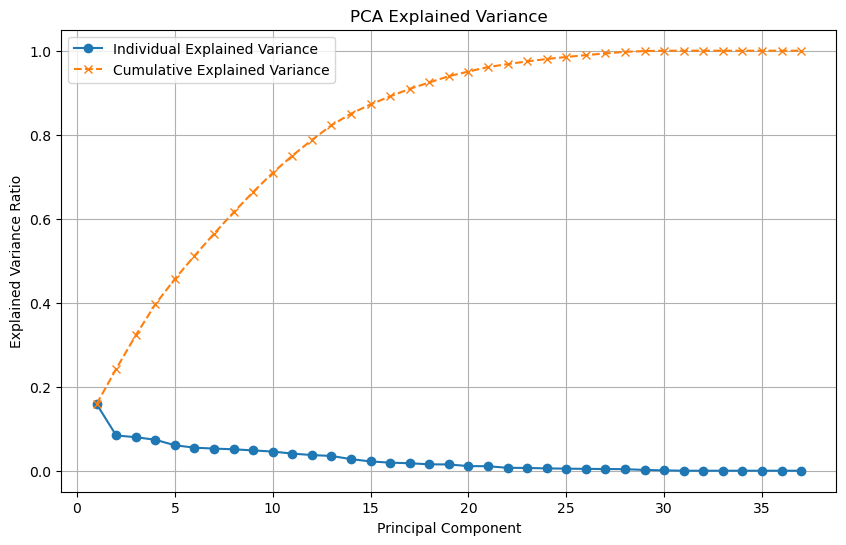

In [7]:
# Applying PCA to the cleaned dataset
pca = PCA()
pca.fit(cleaned_df)

# Calculate the explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_explained_variance = explained_variance_ratio.cumsum()

# Plotting the explained variance and cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', label='Individual Explained Variance')
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='x', linestyle='--', label='Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Determine the number of components that account for 85% of the variance
n_components_85_variance = np.argmax(cumulative_explained_variance >= 0.85) + 1

# Apply PCA with the determined number of components
pca_85 = PCA(n_components=n_components_85_variance)
pca_85_result = pca_85.fit_transform(cleaned_df)

# Convert the result back to a DataFrame for inspection
pca_85_df = pd.DataFrame(
    pca_85_result,
    columns=[f'PC{i+1}' for i in range(n_components_85_variance)],
    index=cleaned_df.index
    )

# Display the number of components and the head of the DataFrame
display(pca_85_df.head())
n_components_85_variance

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  1.803734  0.373896 -0.251600  0.624216 -1.687288 -0.411579 -0.464480   
1 -0.024645  0.712658 -0.606661 -0.223289 -0.005769 -0.580557 -0.921821   
2 -0.823211  0.626466 -1.237952 -0.099686  0.234451 -0.134602  0.038152   
3  0.847369  0.899097 -0.715190 -0.411812 -0.798456 -0.199464 -0.326965   
4 -0.897443 -0.330953  0.017150 -0.073403 -0.135105  0.178131 -1.349435   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  
0  0.375608 -0.355717 -0.132868  0.422722  0.063961 -0.616297  0.089616  
1 -0.601945 -0.294017  0.709068  0.045151 -0.115518 -0.296996  0.090493  
2 -0.166413  0.752253 -0.497863  0.996366  0.693892 -0.256080  0.191138  
3  0.167487  0.215816 -0.381565 -0.324084 -0.137197  0.236730 -0.045836  
4 -0.667924  0.750532 -0.115900  0.103107 -0.437695  0.061946  0.065376

np.int64(14)

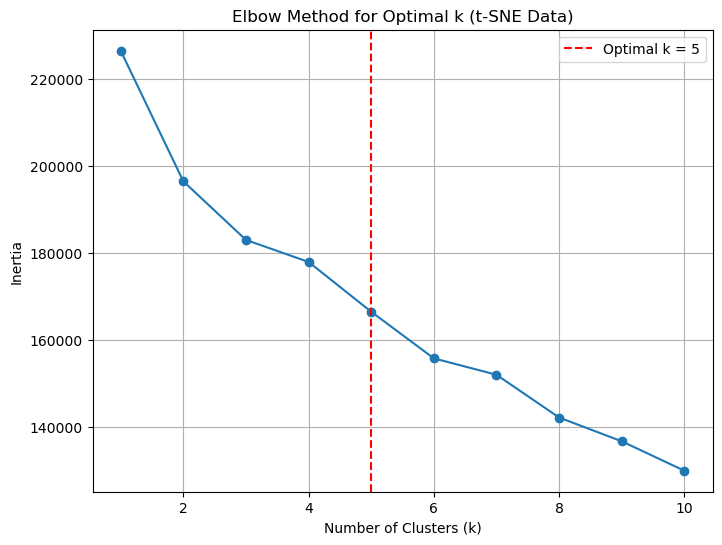

np.int64(5)

In [10]:
# Determine the optimal number of clusters using the Elbow method
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_85_result)
    inertia.append(kmeans.inertia_)

# Use KneeLocator to find the elbow point
kneedle = KneeLocator(k_range, inertia, curve='convex', direction='decreasing')
optimal_k = kneedle.elbow

# Plotting the Elbow method graph with the knee point
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.axvline(optimal_k, color='r', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k (t-SNE Data)')
plt.legend()
plt.grid(True)
plt.show()

optimal_k

/opt/conda/envs/term_deposit-cluster/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


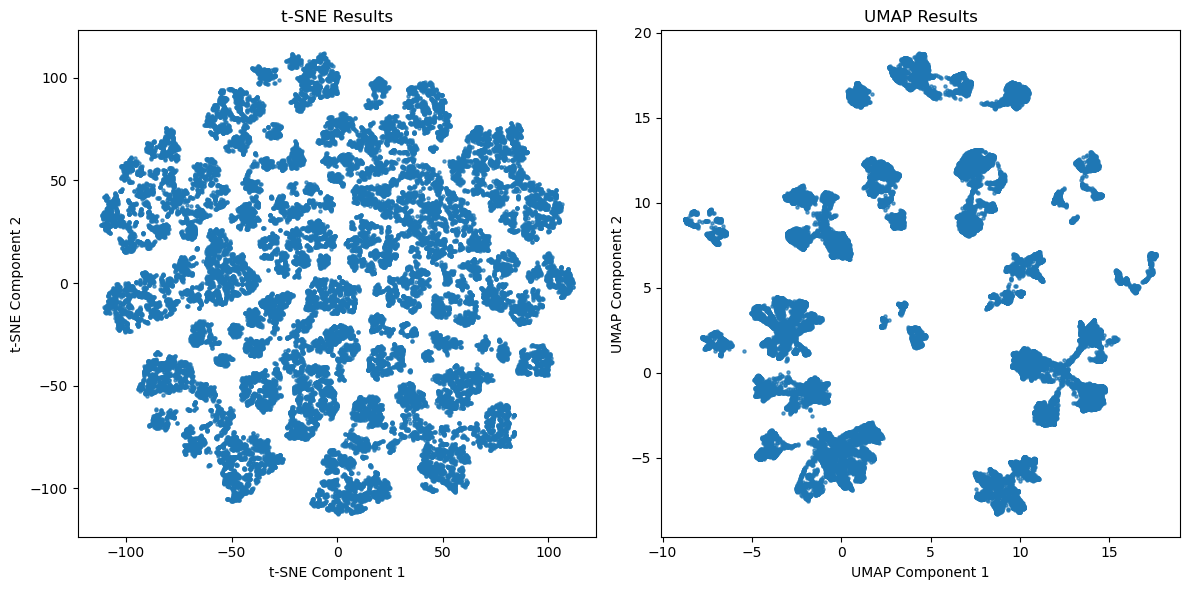

In [15]:
# Applying t-SNE for dimensionality reduction to 2 components
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(pca_85_df)

# Applying UMAP for dimensionality reduction to 2 components
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_reducer.fit_transform(pca_85_df)

# Plotting the t-SNE results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=5, alpha=0.7)
plt.title('t-SNE Results')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Plotting the UMAP results
plt.subplot(1, 2, 2)
plt.scatter(umap_results[:, 0], umap_results[:, 1], s=5, alpha=0.7)
plt.title('UMAP Results')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')

plt.tight_layout()
plt.show()

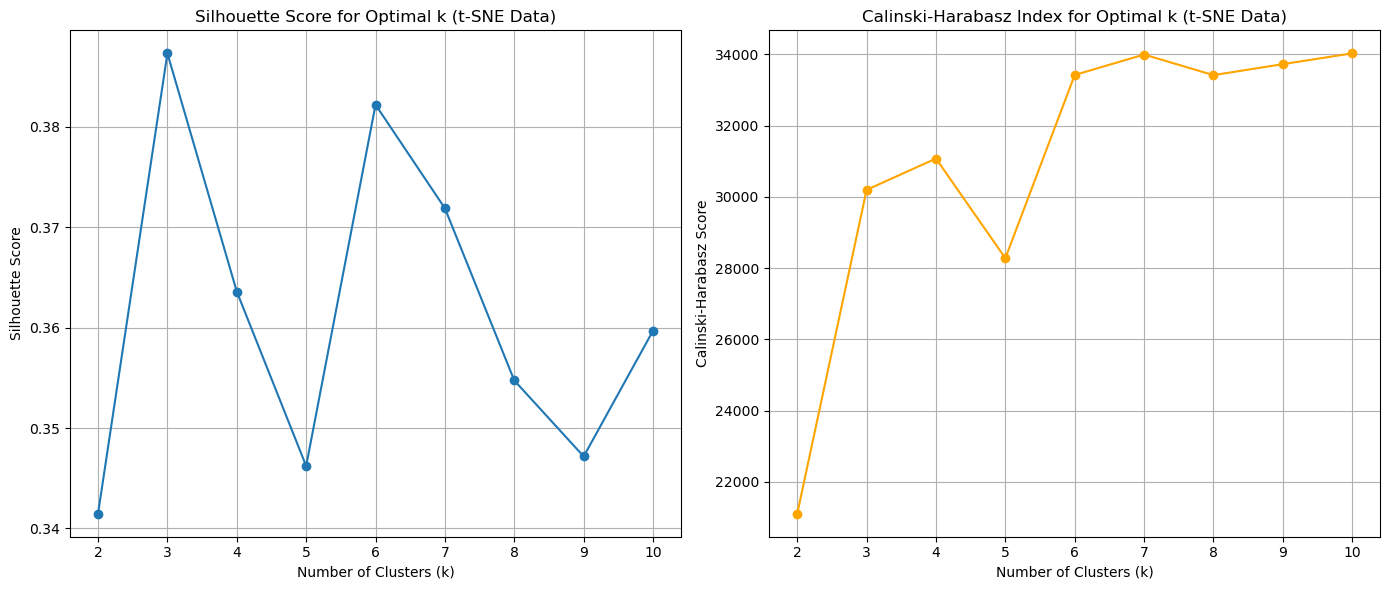

In [16]:
# Define a range of cluster numbers to test
k_range = range(2, 11)

# Lists to store silhouette scores and Calinski-Harabasz scores
silhouette_scores = []
calinski_harabasz_scores = []

# Compute silhouette score and Calinski-Harabasz score for each k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(tsne_results)
    
    # Calculate the silhouette score
    silhouette_avg = silhouette_score(tsne_results, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    # Calculate the Calinski-Harabasz index
    calinski_harabasz_avg = calinski_harabasz_score(tsne_results, cluster_labels)
    calinski_harabasz_scores.append(calinski_harabasz_avg)

# Plotting the silhouette scores and Calinski-Harabasz scores
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Silhouette Score Plot
ax[0].plot(k_range, silhouette_scores, marker='o')
ax[0].set_xlabel('Number of Clusters (k)')
ax[0].set_ylabel('Silhouette Score')
ax[0].set_title('Silhouette Score for Optimal k (t-SNE Data)')
ax[0].grid(True)

# Calinski-Harabasz Index Plot
ax[1].plot(k_range, calinski_harabasz_scores, marker='o', color='orange')
ax[1].set_xlabel('Number of Clusters (k)')
ax[1].set_ylabel('Calinski-Harabasz Score')
ax[1].set_title('Calinski-Harabasz Index for Optimal k (t-SNE Data)')
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Set the number of clusters based on the analysis
n_clusters = 7

# Applying K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_85_df)

# Calculate the silhouette score and Calinski-Harabasz index for the clustering
silhouette_avg = silhouette_score(pca_85_df, kmeans_labels)
calinski_harabasz_avg = calinski_harabasz_score(pca_85_df, kmeans_labels)

# Adding the cluster labels to the dataset
pca_85_df.loc[:, 'Cluster'] = kmeans_labels

# Display the silhouette score, Calinski-Harabasz index, and the head of the dataset with cluster labels
silhouette_avg, calinski_harabasz_avg
display(pca_85_df.head())

ImportError: cannot import name 'visualization' from 'term_deposit' (/workspaces/2-term_deposit_marketing/term_deposit/__init__.py)

In [ ]:
# 3D plot of the clusters using PCA
tsne_3d = TSNE(n_components=3, random_state=42)
pca_result_3d = pca_85.fit_transform(pca_85_df)
vis.plot_3d_interactive(pca_result_3d, kmeans_labels, 'PCA')

In [24]:
pca_3d.get_params()

{'copy': True,
 'iterated_power': 'auto',
 'n_components': 3,
 'n_oversamples': 10,
 'power_iteration_normalizer': 'auto',
 'random_state': None,
 'svd_solver': 'auto',
 'tol': 0.0,
 'whiten': False}

In [ ]:
data_clustered = data.join(pca_85_df["Cluster"])
data_clustered.to_parquet("./data/processed/pca_result.parquet", index=False, compression="brotli")

In [21]:
# 3D plot of the clusters using t-SNE
tsne_result_3d = tsne_3d.fit_transform(pca_85_df)
vis.plot_3d_interactive(tsne_result_3d, kmeans_labels, 'PCA')

NameError: name 'vis' is not defined

In [ ]:
# Configure UMAP to have 3 components
umap_3d = umap.UMAP(n_components=3)


umap_result_3d = umap_3d.fit_transform(pca_85_df)
vis.plot_3d_interactive(umap_result_3d, kmeans_labels, 'PCA')

age                                                    balance  \
          count       mean       std   min   25%   50%   75%   max   count   
Cluster                                                                      
0.0      2898.0  32.756039  5.118159  20.0  29.0  32.0  36.0  48.0  2898.0   
1.0      5885.0  34.827867  5.446274  19.0  31.0  34.0  39.0  50.0  5885.0   
2.0      1854.0  32.792341  4.258197  19.0  30.0  33.0  36.0  43.0  1854.0   
3.0      8139.0  35.670107  5.373392  20.0  32.0  35.0  40.0  49.0  8139.0   
4.0      7111.0  36.516664  5.993759  20.0  32.0  37.0  41.0  57.0  7111.0   
5.0      9206.0  52.185531  4.634414  41.0  48.0  52.0  56.0  69.0  9206.0   
6.0      2490.0  51.839357  5.040365  41.0  48.0  52.0  56.0  69.0  2490.0   

                      ... duration         campaign                           \
                mean  ...      75%     max    count      mean       std  min   
Cluster               ...                                                      
0.0       896.862664  ...   767.75  1032.0   2898.0  2.173223  1.466816  1.0   
1.0      1019.657774  ...   253.00   993.0   5885.0  2.175021  1.240034  1.0   
2.0       684.984898  ...   193.00   836.0   1854.0  7.337648  2.053078  4.0   
3.0       955.520211  ...   254.00   717.0   8139.0  1.951468  1.122604  1.0   
4.0       851.179722  ...   261.00   959.0   7111.0  2.070173  1.219623  1.0   
5.0      1217.953834  ...   306.00  1032.0   9206.0  1.777754  0.856663  1.0   
6.0      1074.971888  ...   203.75  1032.0   2490.0  6.254618  2.130964  4.0   

                              
         25%  50%  75%   max  
Cluster                       
0.0      1.0  2.0  3.0  12.0  
1.0      1.0  2.0  3.0   8.0  
2.0      6.0  7.0  9.0  12.0  
3.0      1.0  2.0  2.0   8.0  
4.0      1.0  2.0  3.0   9.0  
5.0      1.0  2.0  2.0   6.0  
6.0      5.0  6.0  7.0  12.0  

[7 rows x 40 columns]

/tmp/ipykernel_32485/702466972.py:15: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_32485/702466972.py:15: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_32485/702466972.py:15: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_32485/702466972.py:15: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_32485/702466972.py:15: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_32485

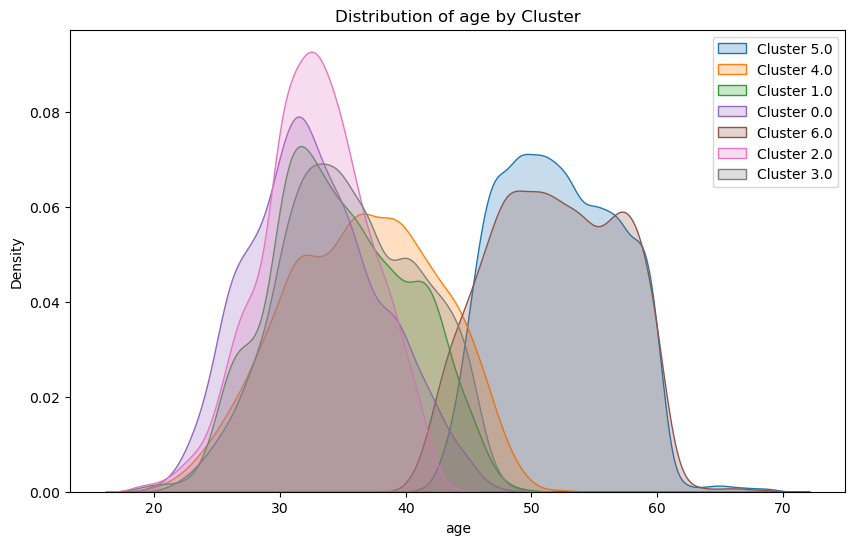

/tmp/ipykernel_32485/702466972.py:15: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_32485/702466972.py:15: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_32485/702466972.py:15: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_32485/702466972.py:15: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_32485/702466972.py:15: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_32485

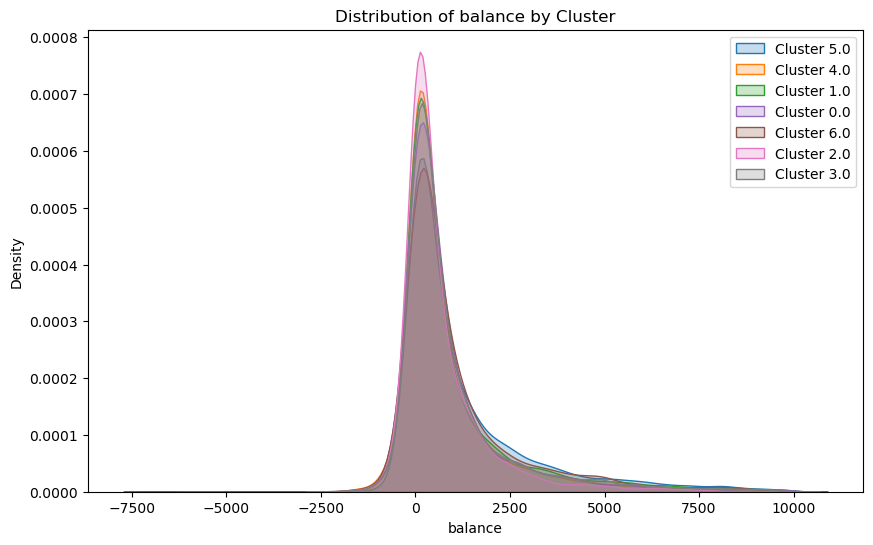

/tmp/ipykernel_32485/702466972.py:15: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_32485/702466972.py:15: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_32485/702466972.py:15: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_32485/702466972.py:15: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_32485/702466972.py:15: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_32485

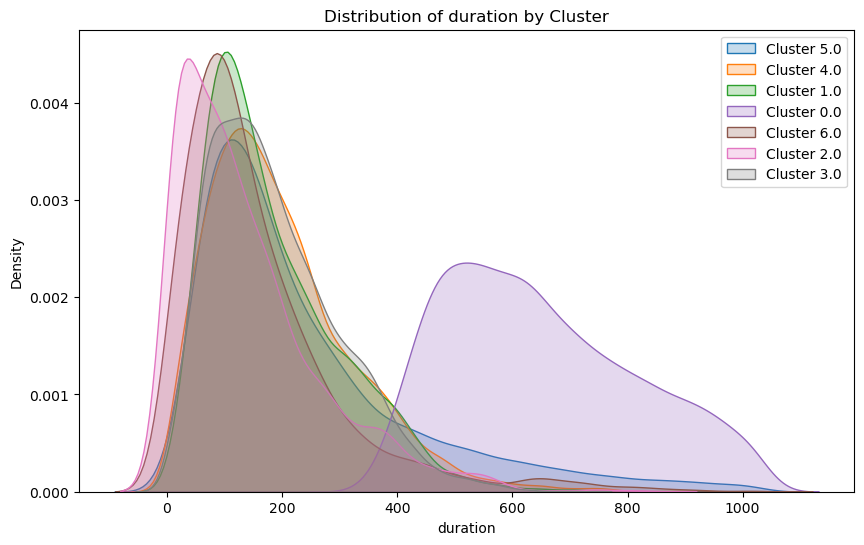

/tmp/ipykernel_32485/702466972.py:15: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_32485/702466972.py:15: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_32485/702466972.py:15: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_32485/702466972.py:15: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_32485/702466972.py:15: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_32485

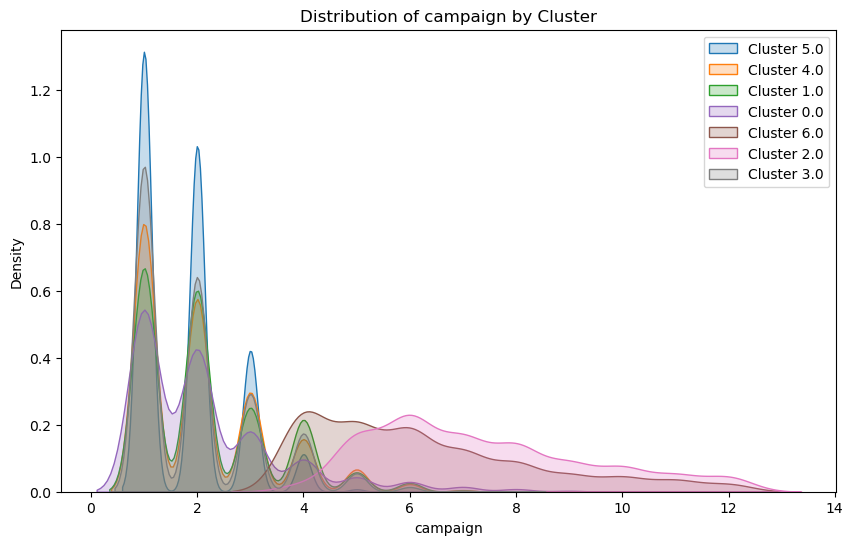

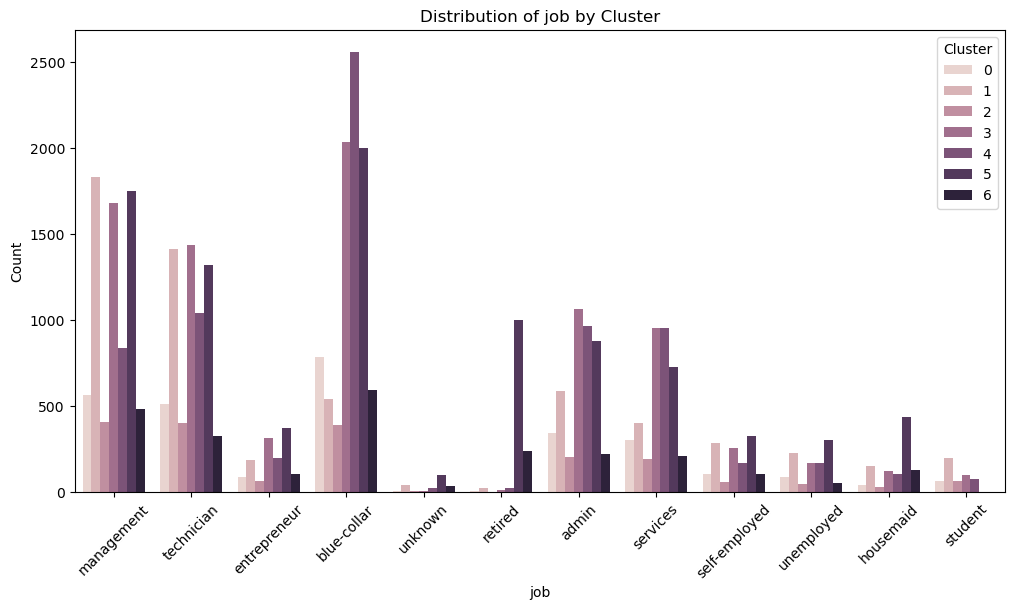

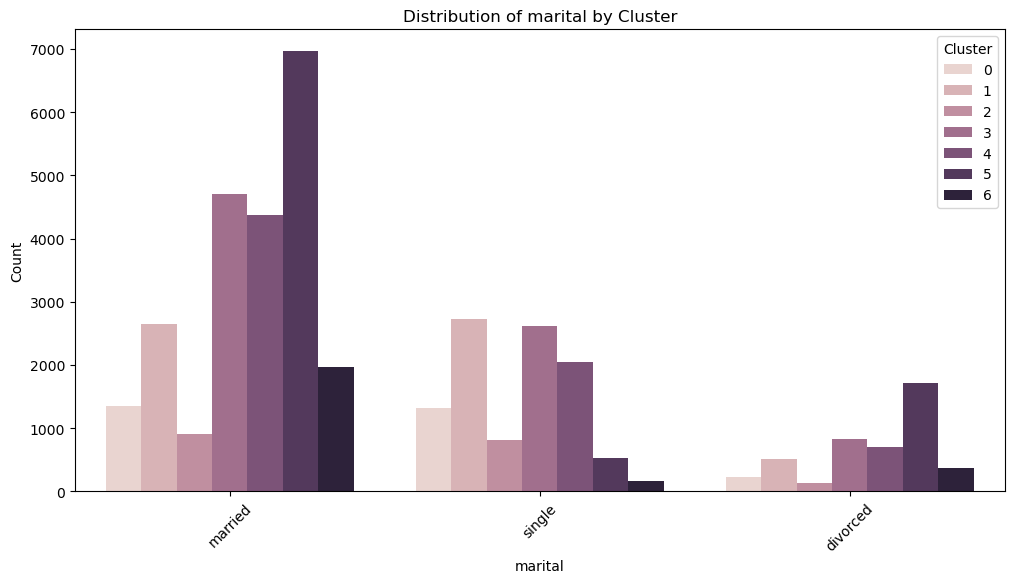

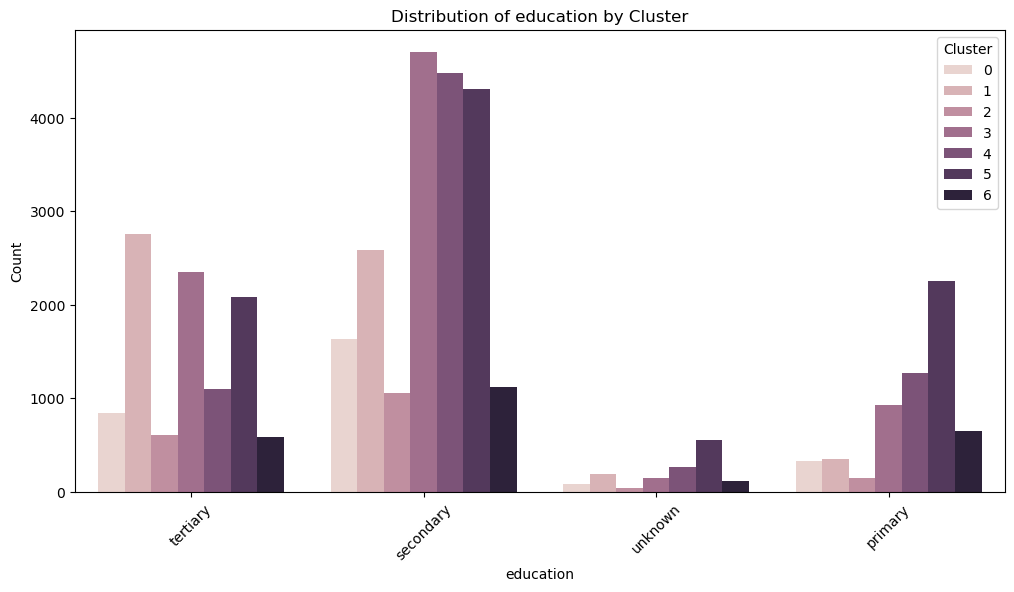

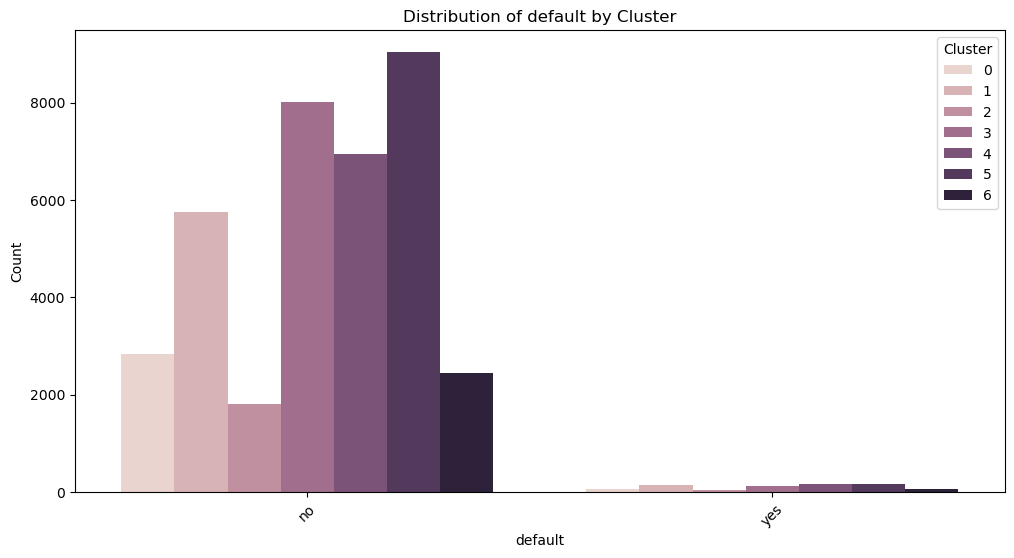

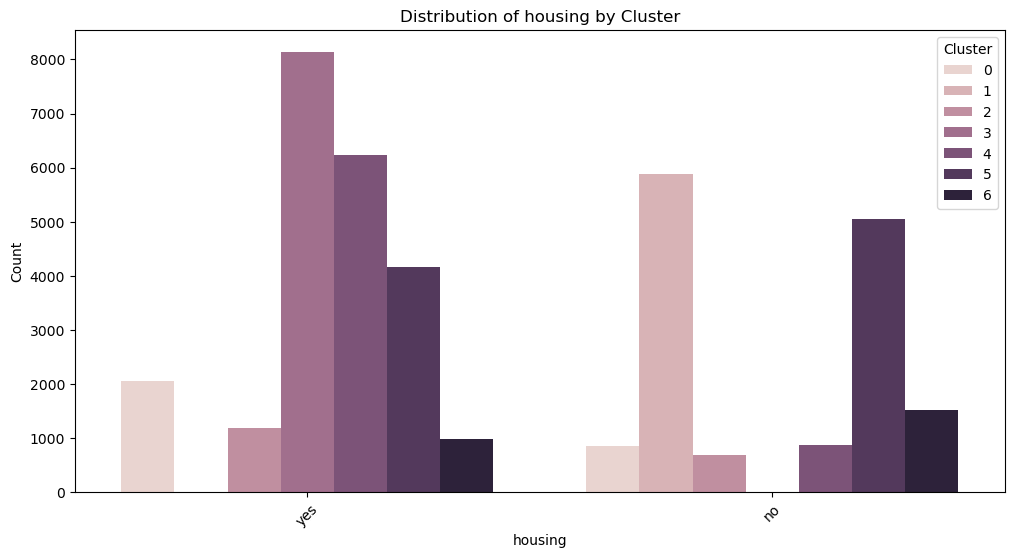

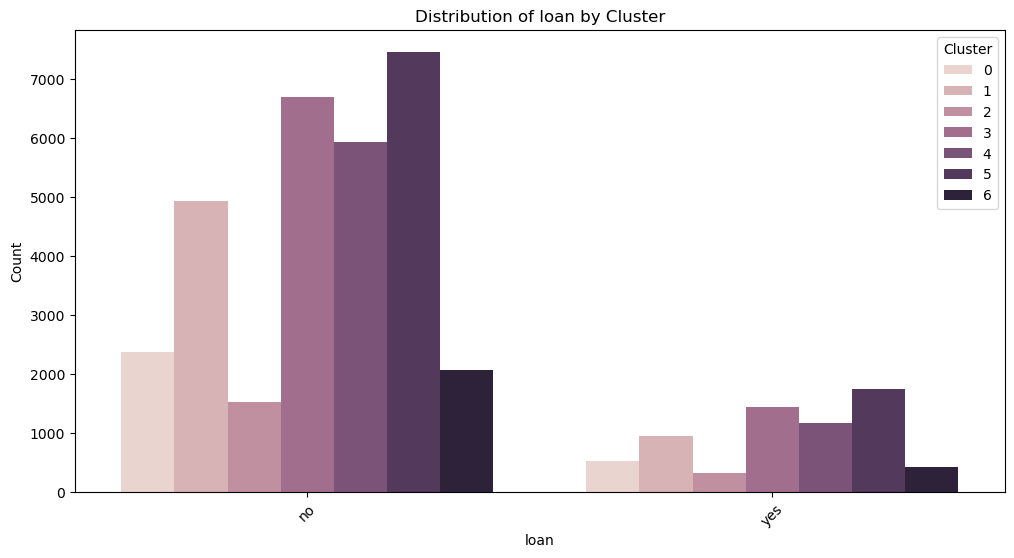

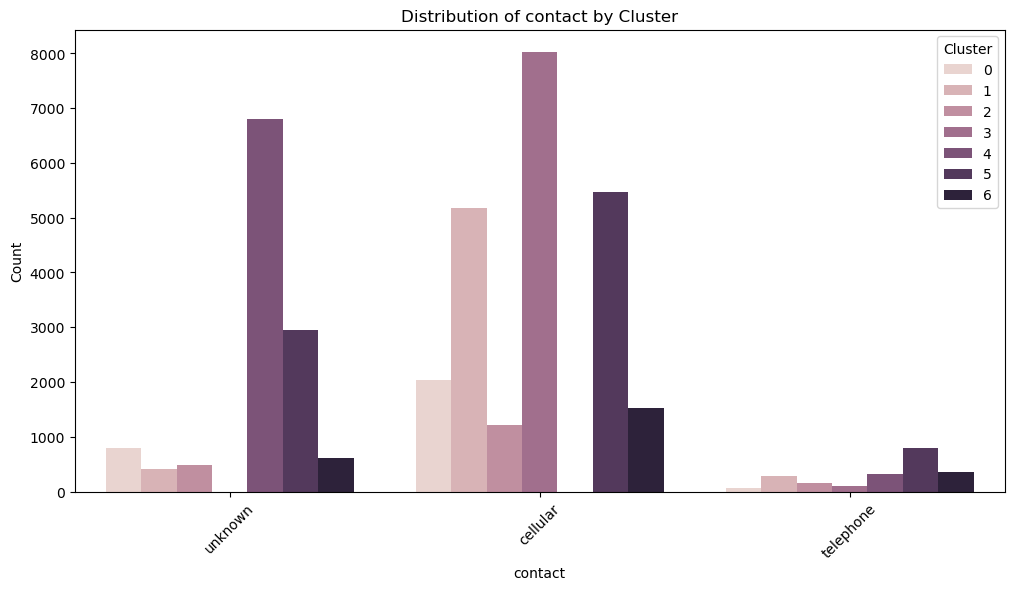

In [ ]:
# Group the data by clusters and calculate descriptive statistics
cluster_summary = data_clustered.groupby('Cluster').describe()

# Display the summary statistics for each cluster
display(cluster_summary)

# Visualize the distribution of numerical features across clusters
numerical_columns = ['age', 'balance', 'duration', 'campaign']
for column in numerical_columns:
    plt.figure(figsize=(10, 6))
    for cluster in data_clustered['Cluster'].unique():
        subset = data_clustered[data_clustered['Cluster'] == cluster]
        sns.kdeplot(subset[column], label=f'Cluster {cluster}', shade=True)
    plt.title(f'Distribution of {column} by Cluster')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Visualize the distribution of categorical features across clusters
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact']
for column in categorical_columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=data_clustered, x=column, hue='Cluster')
    plt.title(f'Distribution of {column} by Cluster')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.legend(title='Cluster')
    plt.xticks(rotation=45)
    plt.show()